In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import interp1d, interp2d
import sofi
import sofiism as si
from time import time
from scipy import signal
import pandas as pd
from gaussfitter_as import gaussfit
import cv2
import gaussfitter as gs
from scipy.optimize import curve_fit
import joblib
import control as ctr
import time

In [4]:

## Change trigger ID in later function
def upload_file(data_folder, filename):
    """
    upload SPAD binary file and retrieve timestamps and addreses of each tag in two separate tables 
    """
    global a
    fh =np.fromfile(data_folder+filename,dtype =np.uint8)
    fh1= np.array(fh.reshape(-1,4))
    print(fh1[:8,:])
    fh2 = np.array(np.fliplr(fh1))
    fh3 = np.unpackbits(fh2[1:-1,:]).reshape(-1,32)

    addr = np.array(np.fliplr(fh3[:,0:6]))
    timestamp = np.array(np.fliplr(fh3[:,6:]))
    val_addr = np.packbits(addr,axis=1,bitorder='little')-32
    val_timestamp = np.packbits(timestamp,axis=1,bitorder='little')
    val_timestamps = val_timestamp[:,0]+2**8*val_timestamp[:,1]+2**16*val_timestamp[:,2]+\
                    2**24*val_timestamp[:,3]
    return(val_addr,val_timestamps)
def detector_intensity(val_addr):
    """
    Check intensity of each detector and triggers(position 23 and 24 in return table)
    """
    
    return(np.unique(val_addr, return_counts=True)[1])


def time_unwrap(val_timestamps):
    """
    Unwrap timestamps into one nondecresing series 
    """
    a=val_timestamps.shape[0]
    val_time =val_timestamps.astype('int64')
    for i in range(a-1):
        if val_time[i+1]-val_time[i]<-1*2**25:
            val_time[i+1:]+=2**26

    return(val_time)
def histogram_creation(val_addr,val_time,time_range):
    """
    Creates g2 correlation histogram
    middle row(position time_range)-tags in the same time
    time_range-maximum registered tag difference
    
    """
    a=val_time.shape[0]
    hist = np.zeros((23,23,2*time_range+1))
    for i in range(a-1):
        b=1    
        diff = val_time[i+b]-val_time[i]

        while diff<=time_range and diff>=0:
            if val_addr[i]<25 and val_addr[i+b]<25:
                hist[val_addr[i],val_addr[i+b],time_range+diff]+=1
                hist[val_addr[i+b],val_addr[i],time_range-diff]+=1
            b+=1
            try:
                diff = val_time[i+b]-val_time[i]
            except:
                break
    return(hist)
def calc_correction(mode='create', channels=23,hist=[],counts_detec=[],filename=''):
    """
    mode create - calculate correction parameters and save it in pkl file
    mode upload - upload correction parameters from pkl file
    """
    if mode =='create':
        correction = np. zeros((channels,channels))
        correction_extra  = np. zeros((18,3))
        for i in range(channels):
            for j in range(channels):
                if i!=j:
                    correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
                if i+5==j:

                    correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
        joblib.dump((correction,correction_extra),filename)
        return(correction,correction_extra)
    elif mode == 'upload':
        (correction,correction_extra) =joblib.load(filename)
        return(correction,correction_extra)
def histogram_correction(hist,correction,correction_extra,counts_detec,middle_row):
    """
    Correct histograms using near 0 delay correction parameters
    
    """
    hist_corrected = np.copy(hist)
    for i in range(23):
        for j in range(23):
            if i!=j:
                hist_corrected[i,j,middle_row] -=(counts_detec[i]+counts_detec[j])*correction[i,j]
            if i+5==j:
                hist_corrected[i,j,middle_row+1] -=(counts_detec[i])*correction_extra[i,0]
                hist_corrected[j,i,middle_row-1] -=(counts_detec[i])*correction_extra[i,0]            
                hist_corrected[i,j,middle_row+2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[j,i,middle_row-2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[i,j,middle_row+3] -=(counts_detec[i])*correction_extra[i,2]
                hist_corrected[j,i,middle_row-3] -=(counts_detec[i])*correction_extra[i,2]
    return(hist_corrected)

def scan_points(val_addr,x_points,y_points):
    """
    finding triggers inside tags list and return list of all tags as numpy array
    ok
    """

    a = len(val_addr)
    pixels = np.zeros((y_points,x_points))
    lines = np.where(val_addr==234)[0]

    if lines.shape ==(0,):
        lines = np.array([0,a])
    else:
        lines =np.concatenate((lines,[a]))
    for i in range(y_points):
        part = val_addr[lines[i]:lines[i+1]]
        pix = np.concatenate(([0],np.where(part==233)[0],[lines[i+1]-lines[i]]))
        print(pix)
        if i%2==0:
            pixels[i] = lines[i] + pix[:-1]
        else:
            pixels[i] = lines[i] + np.flip(pix[:-1])
    return(pixels,lines)


def counts_scan(val_addr,val_timestamps,pixels,dwell_time):
    """
    return number of counts of every detector/every pixel in desired dwell time
    dwell time in miliseconds
    """
    dwell_time = int(dwell_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((x,y,23))
    for i in range(x):
        print('line',i)
        for j in range(y):
            
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        counts[i,j,val_addr[int(pixels[i,j]+delta)]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        counts[i,y-1-j,val_addr[int(pixels[i,y-1-j]+delta)]] += 1
                    delta += 1

    return(counts)

def counts_scan_binned(val_addr,val_timestamps,pixels,dwell_time,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    dwell_time = int(dwell_time * 1e5)
    bin_time = int(bin_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((int(np.ceil(dwell_time/bin_time)),x,y,23))
    for i in range(x):
        print('line',i)
        for j in range(y):
            delta= 0
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,j])+delta]- val_timestamps[int(pixels[i,j])])/bin_time))
                        counts[bin_number,i,j,val_addr[int(pixels[i,j])+delta]] += 1
                    delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        bin_number = int(np.floor((val_timestamps[int(pixels[i,y-1-j])+delta]- val_timestamps[int(pixels[i,y-1-j])])/bin_time))
                        counts[bin_number,i,y-1-j,val_addr[int(pixels[i,y-1-j])+delta]] += 1
                    delta += 1
    return(counts)


def counts_scan_binned_add(counts,val_addr,val_timestamps,pixels,dwell_time,bin_time,x,y):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    Add result to existing counts table
    """

    counts1 = np.zeros(1,(np.ceil(dwell_time/bin_time),x,y,23))
    for i in range(x):
        for j in range(y):
            delta= 0
            while val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]]<dwell_time:
                bin_number = np.floor(val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]])
                counts1[0,bin_number,i,j,val_addr[pixels[i,j]+delta]] += 1
                delta += 1
    counts = np.concatenate((counts,counts),axis = 0)
    return(counts)        
        
def histogram_plot(val_addr):
    """
    Create a detector heat map for certain range of tags
    """
    pos = np.zeros((val_addr.shape[0],2))
    for i in range(val_addr.shape[0]):
        if i%1e6==0:
            print(i)
        temp=val_addr[i]
        if temp<25:
            if temp<=4:
                pos[i,0]=np.sqrt(3)
                pos[i,1] = temp-2.
            elif temp<=8:
                pos[i,0]=np.sqrt(3)/2.
                pos[i,1] = temp-6.5            
            elif temp<=13:
                pos[i,0]=0
                pos[i,1] = temp-11. 
            elif temp<=17:
                pos[i,0]=-np.sqrt(3)/2.
                pos[i,1] = temp-15.5  
            elif temp<=23:
                pos[i,0]=-np.sqrt(3)
                pos[i,1] = temp-20.
    plt.hexbin(pos[:,1],pos[:,0],gridsize=(4,2))
    plt.colorbar()
    plt.show()
    return(pos)

def counts_binned(val_addr,val_timestamps,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    bin_time = int(bin_time * 1e5)
    max_time = max(val_timestamps)
    counts = np.zeros((int(np.ceil(max_time/bin_time)),23))

    for i  in range(len(val_addr)):
        if val_addr[i]<25:
            bin_number = int(np.floor((val_timestamps[i])/bin_time))
            counts[bin_number,val_addr[i]] += 1
           
    return(counts)


(correction,correction_extra)= joblib.load('correction_parameters_laser.pkl')
vx=np.load('vx_06_07_2020.npy')
vy=np.load('vy_06_07_2020.npy')


In [31]:
#intensity scan analysis with time binning
#final data- (counts) intensity value of each pixel in every scan point binned 
# format :(x,y,detector)
# dwell and bin times in ms
nanoSPAD_X= 20
nanoSPAD_Y= 20
dwell_time = 250
bin_time = 0.01
val_addr, val_timestamps  = upload_file(data_folder="./data/NANOspad/2020.07/",filename = "5mhz_15_07_v2")
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X+1,y_points = nanoSPAD_Y)

#Counts variables(with/without binning)
#counts = counts_scan(val_addr,val_time,points,dwell_time = dwell_time)
s = counts_scan_binned(val_addr,val_time,points,dwell_time = dwell_time, bin_time = bin_time)

[[255 255 255 239]
 [ 90  37   0 128]
 [210  37   0 172]
 [ 21  47   0 148]
 [190  78   0 128]
 [ 37 109   0 128]
 [  2 142   0 212]
 [ 70 189   0 208]]
[     0  36929  70005 100349 128209 155551 181870 208398 234907 262722
 290880 318898 347759 376704 405124 433343 461414 488667 515474 541682
 567698 593630]
[     0  28222  55942  84322 112943 141432 170761 200744 231199 261965
 292828 323667 354254 383586 411815 438280 463263 487605 511604 536279
 561714 589407]
[     0  27660  53392  78876 103860 129215 155714 182966 212213 243446
 276198 309651 342948 376900 410194 442452 474162 504362 533976 562733
 590765 619090]
[     0  31895  63970  98003 132656 168147 204693 242925 281126 319302
 356959 393558 429210 463814 496562 526816 555256 582205 607878 633214
 657554 682225]
[     0  25869  51791  78565 105635 134025 164507 197464 232891 270480
 311419 353607 397720 443053 488955 534354 577677 618860 658519 696360
 732005 766379]
[     0  41399  85325 132371 183049 236759 293454 353123 

In [36]:
scans=np.zeros((1,s.shape[0],s.shape[1],s.shape[2],s.shape[3]+1))
scans[0,:,:,:,:-2]=np.concatenate((s[:,:,:,:14],s[:,:,:,15:]),axis=3)

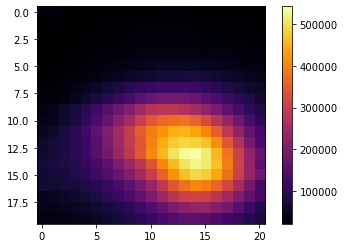

In [32]:
plt.imshow(scans.sum(axis=(0,1,4)))
plt.colorbar()

In [34]:
xc2=si.get_xc2(scans[0,:,:,:,:],vx,vy,1)

In [47]:
np.max(scans)

13.0

-20.150948729856918


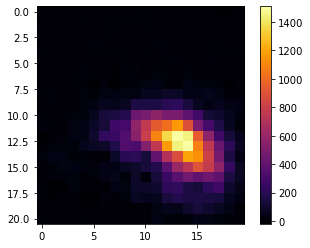

In [35]:
plt.imshow(xc2.T)
plt.colorbar()
print(np.min(xc2))

In [45]:

start=time.time()

xc2=si.get_xc2(scans[0,:,:,:,:],vx,vy,1).T
print(time.time()-start)
#for i in range(3):
#    print(i)
#    xc2+=si.get_xc2(scans[0,:,:,:,:],vx,vy,2+i).T

23.450999975204468


-0.19195693399553265


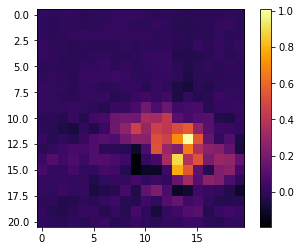

In [43]:
plt.imshow(xc2)
plt.colorbar()
print(np.min(xc2))

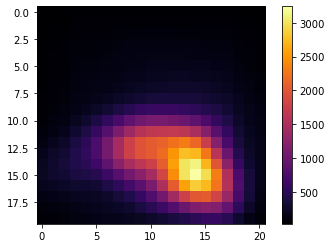

In [33]:
plt.imshow(si.ac1_image(scans,vx,vy))
plt.colorbar()